In [37]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2
from sklearn.metrics import balanced_accuracy_score, adjusted_mutual_info_score, brier_score_loss, mutual_info_score, accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from collections import defaultdict

In [38]:
import os
os.chdir('/Users/lucblassel')

In [39]:
# to_load data
dirname = 'whole_dataset_multi_targets'
# averaged_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_averaged_preds.tsv'), sep='\t', index_col=0)
# subset_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_subset_preds.tsv'), sep='\t', index_col=0)
# cleaned_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_cleaned_preds.tsv'), sep='\t', index_col=0)

In [40]:
# grouper = ['task', 'dataset', 'subtype', 'shorthand', 'num']
grouper = ['task', 'target', 'dataset', 'subtype', 'shorthand']
# task_order = ['all features\nkept', 'DRM features\nremoved','DRM features &\nDRM sequences \nremoved']
task_order = ['all features\nkept', 'DRM features\nremoved']#, 'DRM features &\nDRM sequences\nremoved']
target_order = ['encoded_label', 'hasDRM']

# Data cleaning / gathering
You can skip this ig the avove cells read precomputed tsv files

In [41]:
# all_preds = pd.read_csv('all_preds_with_boosting.tsv', sep='\t', index_col=0)
# all_preds = pd.read_csv('whole_dataset_all_preds.tsv', sep='\t', index_col=0)
all_preds = pd.read_csv(os.path.join(dirname, 'all_preds.tsv'), sep='\t', index_col=0)
all_preds['shorthand'] = all_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

In [42]:
all_preds

,task,subtype,shorthand,real,dataset,target,pred,hasDRM,sample_subtype
index,,,,,,,,,
0001_BF01n_BF_URF_SR050_19_18,DRM features\nremoved,ALL,FC,0,Africa,encoded_label,0,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,DRM features\nremoved,ALL,FC,0,Africa,hasDRM,0,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,DRM features\nremoved,ALL,B2,0,Africa,encoded_label,0,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,DRM features\nremoved,ALL,B2,0,Africa,hasDRM,0,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,DRM features\nremoved,ALL,BH1,0,Africa,encoded_label,0,0.0,CRF06_cpx
...,...,...,...,...,...,...,...,...,...
9999,all features\nkept,B,RF,1,UK different,hasDRM,1,1.0,C
9999,all features\nkept,B,SD1,0,UK different,encoded_label,0,1.0,C
9999,all features\nkept,B,SD1,1,UK different,hasDRM,0,1.0,C


In [43]:
subset_preds = all_preds[
                (all_preds['task'].isin(task_order)) & 
                (
                    ((all_preds['dataset'] == 'UK') & (all_preds['subtype'].isin(['B', 'C']))) |
                    ((all_preds['dataset'] == 'Africa') & (all_preds['subtype'] == 'ALL'))
                )
            ]

In [44]:
metadata = pd.concat(
    [pd.read_csv(os.path.join('/Users/lucblassel/Documents/Work/hiv-drm-detection/data_pre_split',name), sep='\t', index_col=0)
    for name in ['uk-metadata.tsv', 'africa-metadata.tsv']]
)
metadata.index = metadata.index.astype(str)

In [45]:
subset_preds.index = subset_preds.index.astype(str)
subset_preds['encoded_label'] = metadata['encoded_label']

# Computing scores 
We need to compute AMI and/or balanced accuracy for the RF/LR/NB and fisher test based classifier on the 3 tasks. showing everything: 
 - trained on B, tested on C
 - trained on C, tested on B
 - trained on ALL, tested on Africa
 

In [46]:
def get_scores(df):
    scorer = {'AMI':adjusted_mutual_info_score, 'bal acc':balanced_accuracy_score, 'accuracy':accuracy_score}
    scores = {}
    for name, function in scorer.items():
        scores[name] = function(df['real'], df['pred'])
    return pd.Series(scores)

In [47]:
def get_pvalue(df):
    N = df.shape[0]
    m_i = mutual_info_score(df['real'], df['pred'])
    G_stat = m_i * 2 * N 
    return 1 - chi2.cdf(G_stat, df=1)

scores_cleaned: the sequences with DRMs are removed from the test set for models trained without them 

In [48]:
scores = subset_preds.groupby(grouper).apply(get_scores)
p_values = subset_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted = pd.melt(scores.reset_index(), id_vars=grouper)
melted['group'] = melted['task'] + ' ' + melted['subtype']
melted['group2'] = melted['target'] + ' ' + melted['subtype']

In [49]:
def bonferroni(df, alpha=0.05):
    N = df.shape[0]
    df['bonferroni'] = df['p_value'] <= (alpha / N)
    return df

In [50]:
corrected = p_values.groupby('subtype').apply(bonferroni).set_index(['subtype', 'task', 'shorthand', 'target'])

## Brier probas stuff

In [68]:
probas = pd.read_csv(os.path.join(dirname, 'raw_preds.tsv'), sep='\t', index_col=0)
probas['shorthand'] = probas['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

In [69]:
subset_probas = probas[
                (probas['task'].isin(task_order)) & 
                (
                    ((probas['dataset'] == 'UK') & (probas['subtype'].isin(['B', 'C']))) |
                    ((probas['dataset'] == 'Africa') & (probas['subtype'] == 'ALL'))
                )
            ]
# subset_probas.index = subset_probas.index.astype(str)
# subset_probas = subset_probas.join(metadata['hasDRM'])
subset_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM,sample_subtype
index,,,,,,,,,,,,,,
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,hasDRM,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,hasDRM,RF,Africa,19,1.000000,0.000000,all features\nkept,RF,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,hasDRM,Logistic,Africa,0,0.999955,0.000045,all features\nkept,LR,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,hasDRM,RF,Africa,6,1.000000,0.000000,all features\nkept,RF,0.0,CRF06_cpx
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,hasDRM,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,0.0,CRF06_cpx


In [70]:
def get_brier(df):
    model = df['shorthand'].iloc[0]
    if model not in ['NB', 'LR', 'RF']:
        return brier_score_loss(df['real'], df['pred'])
    else:
        return brier_score_loss(df['real'], df['1'])

def get_agnostic_brier(df, target):
    frequencies = {
        'encoded_label': {
            'all features\nkept':
                {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
            'DRM features\nremoved':
                {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
            'DRM features &\nDRM sequences\nremoved':
                {'ALL':0.1864, 'B':0.1729, 'C':0.2116}
        },
        'hasDRM': {
            'all features\nkept':
                {'ALL':0.3252, 'B':0.3540, 'C':0.2638},
            'DRM features\nremoved':
                {'ALL':0.3252, 'B':0.3540, 'C':0.2638}
        }
    }
    subtype = df['subtype'].iloc[0]
    task = df['task'].iloc[0]
    return brier_score_loss(df['real'], [frequencies[target][task][subtype] for _ in df.index])


In [71]:
to_concat = []
to_concat.append(subset_probas.groupby(grouper+['num']).apply(get_brier).rename('brier').reset_index())
for target in ['encoded_label', 'hasDRM']:
    random_score = (subset_probas[(subset_probas['shorthand']=='NB') & (subset_probas['target']==target)].groupby(grouper)
                        .apply(lambda x: get_agnostic_brier(x, target)).rename('brier').reset_index())
    random_score['shorthand'] = 'RD'
    to_concat.append(random_score)
scores_proba = pd.concat(to_concat)
scores_proba['group'] = scores_proba['task'] + ' ' + scores_proba['subtype']
scores_proba['group2'] = scores_proba['target'] + ' ' + scores_proba['subtype']

In [72]:
scores_proba.head()

,brier,dataset,num,shorthand,subtype,target,task,group,group2
0,0.392481,Africa,0.0,B2,ALL,encoded_label,DRM features\nremoved,DRM features\nremoved ALL,encoded_label ALL
1,0.344862,Africa,0.0,BH1,ALL,encoded_label,DRM features\nremoved,DRM features\nremoved ALL,encoded_label ALL
2,0.386717,Africa,0.0,BH2,ALL,encoded_label,DRM features\nremoved,DRM features\nremoved ALL,encoded_label ALL
3,0.419549,Africa,0.0,D1,ALL,encoded_label,DRM features\nremoved,DRM features\nremoved ALL,encoded_label ALL
4,0.419549,Africa,0.0,D2,ALL,encoded_label,DRM features\nremoved,DRM features\nremoved ALL,encoded_label ALL


## Plot preparation

In [73]:
# models = ['NB', 'LR', 'RF', 'FisherBonf1']
models = ['NB', 'LR', 'RF', 'FC']
subtypes = ['ALL', 'B', 'C']
subtype_labels = {
    'ALL': 'trained on UK B&C,\ntested on Africa',
    'B': 'trained on UK B,\ntested on UK C',
    'C': 'trained on UK C,\ntested on UK B'
}

In [74]:
colors = [color for color in sns.palettes.color_palette('muted') for _ in range(3)]
hue_order = [f"{task} {sub}" for task in task_order for sub in subtypes]

In [75]:
repeats = {'big': 3, 'small':4}
patterns = {k:{'B':'/'*n, 'C': '\\'*n} for k,n in repeats.items()} 
hatches = [patterns['big'].get(sub, None) for task in task_order for sub in subtypes for model in models]
small_hatches = [patterns['small'].get(sub, None) for task in task_order for sub in subtypes for model in models]
hatches_multi = [patterns['big'].get(sub, None) for sub in subtypes for target in target_order for model in models]
small_hatches_multi = [patterns['small'].get(sub, None) for sub in subtypes for target in target_order for model in models]
models_ext = models + ['RD']
hatches_ext = [patterns.get(sub, None) for task in task_order for sub in subtypes for model in models_ext]

In [76]:
sns.set_context('poster')
sns.set_palette('muted')

In [77]:
task_handles = [
    Patch(facecolor=color, label=task, lw=1.5, edgecolor='black')
    for color, task in zip(sns.color_palette(), task_order)
    ]
subtype_handles = [
    Patch(
        facecolor="white",
        label=subtype_labels.get(subtype),
        hatch=patterns['small'].get(subtype, ""),
        lw=1.5, edgecolor='black',
    )
    for subtype in subtypes
    ]

legend_handles = (
    [Patch(color="white", label="signal removal:")]
    + task_handles
    + [
        # Patch(color="white", label=""),
        Patch(color="white", label="training scenario:"),
    ]
    + subtype_handles
)

In [78]:
random_handles = (
    Patch(color='white', label=""),
    Line2D([0], [0], color='red', label="expected value\nfor null classifier"),
    Patch(color='white', label=""),
    Patch(color='white', label=""),
)

In [79]:
def get_legend(gen_label=False, context='notebook', hue='task'):
    with sns.plotting_context(context):
        hues = {
            'task': ['all features\nkept\n', 'DRM features\nremoved\n'],
            'target': ['\ntreated vs. naive\n', '\nw/ DRM vs. wo/ DRM\n']
        }
        h1 = [Patch(facecolor=color, label=label, edgecolor='black') 
                for label, color in zip(hues.get(hue, []), sns.color_palette())]
        h2 = [Patch(facecolor="white",label=subtype_labels.get(subtype),hatch=patterns['small'].get(subtype, ""), 
                edgecolor='black',) for subtype in subtypes]
        l = Line2D([0], [0], color='red', label="expected value\nfor null classifier\n")
        e = Patch(color='white', label="")
        labels = [Patch(color="white", label="signal removal:\n\n"), Patch(color="white", label="training scenario:\n")]
    (ncol, handles) = (5, labels) if gen_label else (3, [])
    return (ncol, 
        handles + [h1[0], h2[0]] + [h1[1], h2[1]] + [l, h2[2]]
    )

# Plotting scores

In [80]:
def get_subplot(to_plot, ylabel, annots=None, x='shorthand', y='value', hue='group', order=models, palette=colors, hue_order=hue_order, hatches=hatches, ax=None, title="", title_args=dict(), yticks=None, ylim=None, log=False, xlabel="Classifier"):
    
    kwargs={'ax':ax} if ax is not None else {}
        
    ax = sns.barplot(
        data=to_plot, 
        x=x, 
        y=y,
        hue=hue, 
        order=order,
        hue_order=hue_order, 
        palette=palette, 
        # lw=1.2,
        edgecolor='black',
        ci=None,
        **kwargs
    )
    if annots is None:
        annots = ["" for _ in hatches]
    for patch, hatch, annot in zip(ax.patches, hatches, annots):
        if annot == "*":
            x = patch.get_x() + patch.get_width() / 2
            if log:
                y = (patch.get_y() + patch.get_height()) * 1.05
            else:
                y = (patch.get_y() + patch.get_height()) + 0.01
            ax.text(x, y, annot, ha='center', va='center')
        if hatch is None:
            continue 
        patch.set_hatch(hatch)

    sns.despine()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()
    ax.set_title(title, **title_args)
    if yticks is not None:
        ax.set_yticks(yticks)
    if log:
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax

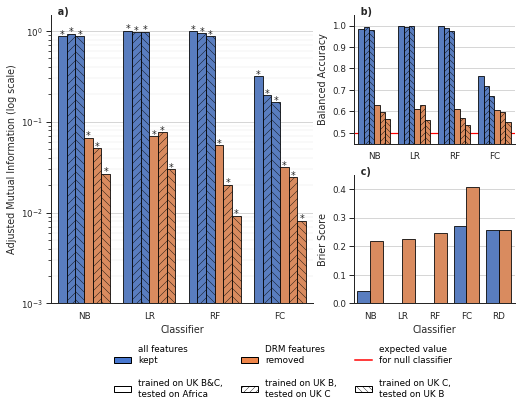

In [81]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots = ["*" if corrected['bonferroni'].get((sub, task, model, 'hasDRM'), False) else "" 
                    for task in task_order for sub in subtypes for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 1, 6)
brier_ticks = np.linspace(0, 0.4, 5)

to_plot_AMI = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'AMI') & (melted['target'] == 'hasDRM')]
to_plot_bal = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'bal acc') & (melted['target'] == 'hasDRM')]
to_plot_brier = scores_proba[(scores_proba['shorthand'].isin(models + ['RD'])) & (scores_proba['subtype'] == 'ALL') & (scores_proba['target'] == 'hasDRM')]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True)
    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches, ylim=(0.45,1.05), xlabel="")
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, 
                hue_order=hue_order[::3], hatches=[], y='brier', palette=sns.color_palette(),
                order=models + ['RD'], ylim=(0, 0.45), yticks=brier_ticks)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = get_legend()
ax4.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)
# ax4.legend(bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.7)
# plt.savefig(os.path.join(dirname, 'perf_log_tight.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

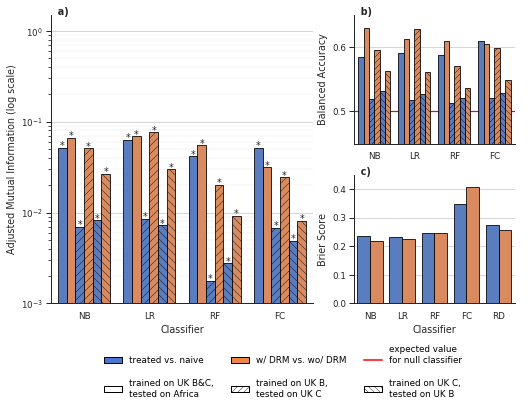

In [82]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots = ["*" if corrected['bonferroni'].get((sub, task_order[1], model, target), False) else "" 
                for sub in subtypes for target in target_order for model in models]
hue_order_multi = [f"{target} {subtype}" for subtype in subtypes for target in target_order]
colors_multi = [col for _ in subtypes for col in (sns.color_palette()[:2])]

title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.6, 2)
brier_ticks = np.linspace(0, 0.4, 5)

to_plot_AMI = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'AMI') & (melted['task'] == task_order[1])]
to_plot_bal = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'bal acc') & (melted['task'] == task_order[1])]
to_plot_brier = scores_proba[(scores_proba['shorthand'].isin(models + ['RD'])) & (scores_proba['subtype'] == 'ALL') & (scores_proba['task'] == task_order[1])]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True, hue='group2', hue_order=hue_order_multi, hatches=hatches_multi, palette=colors_multi)
    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches_multi, ylim=(0.45,0.65), xlabel="", hue='group2', hue_order=hue_order_multi, palette=colors_multi)
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, hue='group2',
                hue_order=hue_order_multi[:2], hatches=[], y='brier', palette=colors_multi,
                order=models + ['RD'], ylim=(0, 0.45), yticks=brier_ticks)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = get_legend(hue='target')
ax4.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.7)
# plt.savefig(os.path.join(dirname, 'perf_log_tight.pdf'), format='pdf', alpha=.99, bbox_inches='tight')

In [83]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', rotation='vertical')

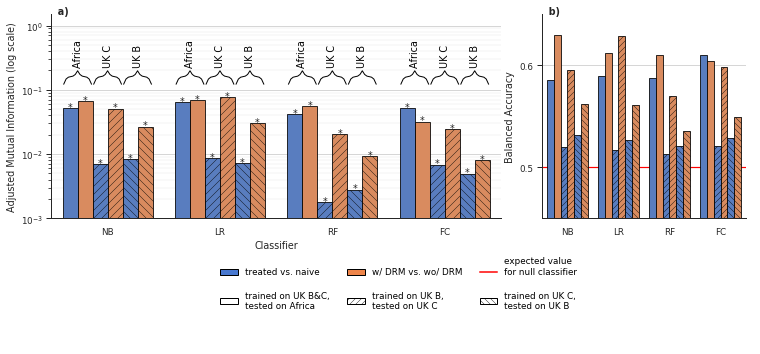

In [84]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
mult = 1.5
fig = plt.figure(figsize=(8.3 * mult, 5.8))

annots = ["*" if corrected['bonferroni'].get((sub, task_order[1], model, target), False) else ""
                for sub in subtypes for target in target_order for model in models]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True, hue='group2', hue_order=hue_order_multi, hatches=hatches_multi, palette=colors_multi)
    ax2 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches_multi, ylim=(0.45,0.65), xlabel="", hue='group2', hue_order=hue_order_multi, palette=colors_multi)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

patch_order = [(sub, model) for sub in subtypes for target in target_order for model in models ]
brace_xs = defaultdict(list)

for patch, (sub, model) in zip(ax1.patches, patch_order):
    brace_xs[(sub, model)].append((patch.get_x(), patch.get_width()))

for (sub, _), pos in brace_xs.items():
    draw_brace(ax1, (pos[0][0]+0.01, sum(pos[1])-0.01), 0.1, {'ALL': ' Africa', 'B': ' UK C', 'C': ' UK B'}.get(sub))

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.axis('off')

ncol, handles = get_legend(hue='target')
ax3.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, 0.5), loc='center', borderaxespad=0, frameon=False)
fig.savefig(os.path.join(dirname, 'performance_compare_tasks.pdf'), format='pdf', alpha=.99, bbox_inches='tight')